In [1]:
from IPython.core.display import display
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pulp
from itertools import product, combinations_with_replacement
from joblib import Parallel, delayed

In [2]:
np.random.seed(10)
num_places = 10 # number of POI
num_days = 30 # plan days
num_requests = 120 # number of orders

In [3]:
mean_travel_time_to_destinations = 100 # average time for all orders
H_regular = 8*60 # 8 hours / day
H_max_overtime = 3*60 # 3 hours / day
c = 3000 // 60 # cost for over time / min
W = 4000 # 4000kg truck
delivery_outsorcing_unit_cost = 4600 # cost 4600 / 100 kg
delivery_time_window = 3 # window days for order
avg_weight = 1000 # average weight of orders

In [4]:
K = range(num_places) # list of POIs
o = 0 # id for center POI
K_minus_o = K[1:] # id list for destination POIs
_K = np.random.normal(0, mean_travel_time_to_destinations, size=(len(K), 2)) #coordinate of POIs
_K[0, :] = 0 #Coordinate of center POI is 0
t = np.array([[np.floor(np.linalg.norm(_K[k] - K[l]))for k in K] for l in K])
D = range(num_days) # list of days


In [5]:
R = range(num_requests) # list of order
#k[r] = distnation for order r
k = np.random.choice(K_minus_o, size=len(R))
#d_0[r] = start date to deliver order r
d_0 = np.random.choice(D, size=len(R))
#d_1[r] = end date to deliver order r
d_1 = d_0 + delivery_time_window - 1
#w[r] = weight for order r
w = np.floor(np.random.gamma(10, avg_weight/10, size=len(R)))
#f[r] = cost of outsourcing order r
f = np.ceil(w/100)*delivery_outsorcing_unit_cost

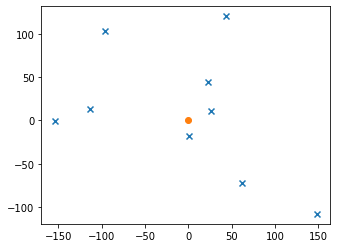

In [6]:
a = plt.subplot()
a.scatter(_K[1:,0], _K[1:,1], marker='x')
a.scatter(_K[0,0], _K[0,1], marker='o')
a.set_aspect('equal')
plt.show()

(array([ 0.,  0.,  0.,  0.,  2.,  9.,  7., 11., 14., 12., 22., 14., 14.,
         9.,  2.,  1.,  2.,  0.,  1.,  0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000.]),
 <BarContainer object of 20 artists>)

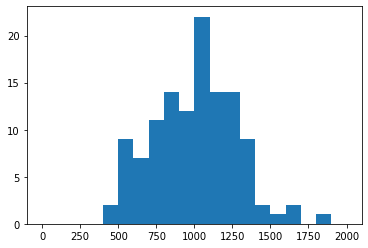

In [7]:
plt.hist(w, bins=20, range=(0,2000))

In [8]:
# create schedules
def simulate_route(z : list):
    # z[k]=1 -> Arrived to POI k
    if z[0] == 0:
        return None # No route don't pass center
    daily_route_prob = pulp.LpProblem(sense=pulp.LpMinimize)

    x = {
        (k, l):pulp.LpVariable(f'x_{k}_{l}a', cat='Binary') 
        if k!=l else pulp.LpAffineExpression() for k, l in product(K, K)
    }

    u = {
        k: pulp.LpVariable(f'u_{k}', lowBound=1, upBound=len(K)-1)
        for k in K_minus_o
    }

    h = pulp.LpVariable('h', lowBound=0, cat='Continuous')

    for l in K:
        daily_route_prob += (
            pulp.lpSum([x[k,l] for k in K]) <= 1
        )
    for l in K:
        if z[l] == 1:
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 1
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 1
            )
        else:
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 0
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 0
            )

    for k,l in product(K_minus_o, K_minus_o): # reduce cycle
        daily_route_prob += (
            u[k] + 1 <= u[l] + len(K_minus_o) * (1-x[k,l])
        )

    travel = pulp.lpSum([t[k,l] * x[k,l] for k, l in product(K,K)])
    daily_route_prob += (travel - H_regular <= h)
    daily_route_prob += (h <= H_max_overtime)

    daily_route_prob += travel
    daily_route_prob.solve()

    return {
        'z':z,
        'route':{(k,l):x[k,l].value() for k,l in product(K,K)},
        'optimal': daily_route_prob.status == 1,
        'moving_time':travel.value(),
        'overtime':h.value()
    }

def enumerate_routes():
    routes = Parallel(n_jobs=16, prefer='threads')(
        [delayed(simulate_route)(z) for z in product([0,1], repeat=len(K))]
    )
    routes = pd.DataFrame(filter(lambda x: x is not None, routes))

    routes = routes[routes.optimal].copy()
    return routes

routes_df = enumerate_routes()